In [ ]:
# Google drive mount 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

ROOT = "/content/drive/MyDrive"
DIR = "dacon/연암공대_퇴근시간"  # data 폴더와 ipynb 파일이 위치한 폴더명을 적으세요.
PATH = os.path.join(ROOT, DIR)
os.chdir(PATH)  # 현재 프로젝트 PATH로 이동

In [ ]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
import os, shutil, random, time, pickle
import numpy as np
from collections import Counter
from sklearn.metrics import mean_squared_error

# data preprocessing
import pandas as pd
pd.set_option('max_columns', 130, 'max_rows', 30)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warining
import warnings
warnings.filterwarnings('ignore')

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import geopy.distance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import random
random.seed(42)

import lightgbm as lgb
from keras import metrics
from sklearn.metrics import r2_score

In [ ]:
bts = pd.read_csv('bus_bts.csv')
sub = pd.read_csv('submission_sample.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train.shape,test.shape

((415423, 19), (228170, 18))

In [ ]:
X_train = train.drop("18~20_ride",axis = 1)
y_train = train["18~20_ride"]
round(train.describe().loc[:,"6~7_ride":],3)

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
count,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000
mean,0.306,0.830,0.815,0.642,0.600,0.579,0.113,0.345,0.516,0.431,0.408,0.403,1.242
std,1.110,2.255,2.318,1.960,1.886,1.942,0.598,1.279,1.659,1.485,1.413,1.446,4.722
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,85.000,94.000,136.000,78.000,124.000,99.000,45.000,66.000,59.000,65.000,52.000,81.000,272.000


In [ ]:
col_t = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff']
print(pd.DataFrame({'train':round((X_train[col_t] <= 1).sum() / len(train) * 100),
                  'test':round((test[col_t] <= 1).sum() / len(test) * 100)}))

               train  test
6~7_ride        94.0  94.0
7~8_ride        84.0  85.0
8~9_ride        84.0  84.0
9~10_ride       87.0  87.0
10~11_ride      88.0  87.0
11~12_ride      89.0  88.0
6~7_takeoff     98.0  98.0
7~8_takeoff     94.0  94.0
8~9_takeoff     90.0  90.0
9~10_takeoff    92.0  91.0
10~11_takeoff   92.0  91.0
11~12_takeoff   92.0  91.0


In [ ]:
pd.DataFrame({'train':train.isnull().sum(),
              'test':test.isnull().sum()}).fillna('')

,train,test
10~11_ride,0,0
10~11_takeoff,0,0
11~12_ride,0,0
11~12_takeoff,0,0
18~20_ride,0,
6~7_ride,0,0
6~7_takeoff,0,0
7~8_ride,0,0
7~8_takeoff,0,0
8~9_ride,0,0


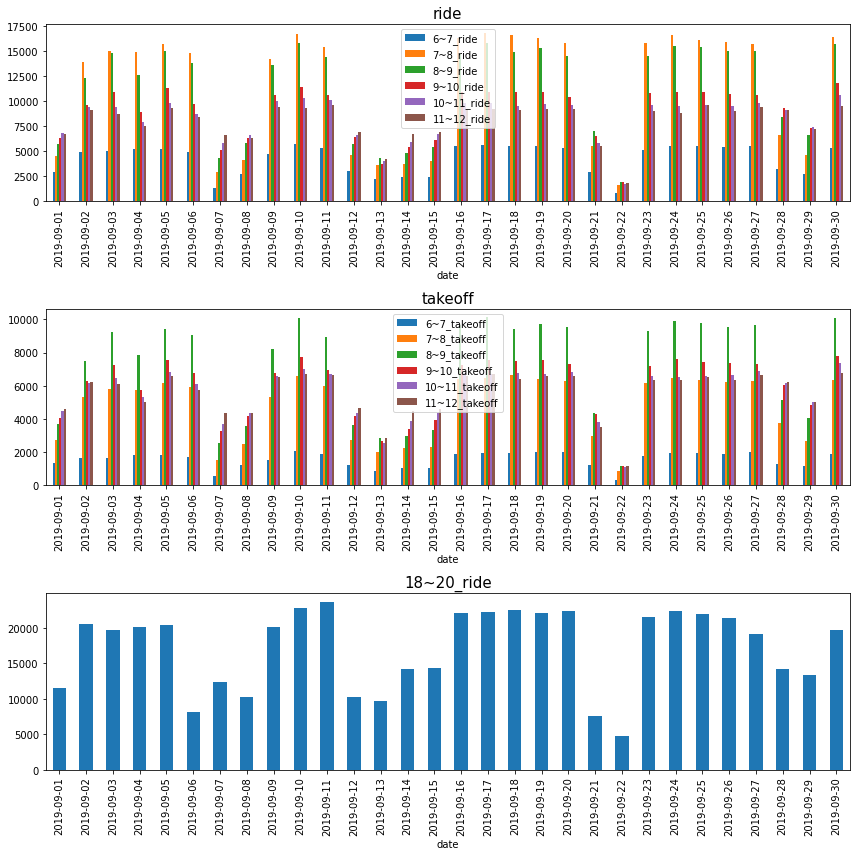

In [ ]:
date_sum_ = train.groupby(['date'])[col_t + ['18~20_ride']].sum()


plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
date_sum_[date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
date_sum_[date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
date_sum_[date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

0          4270000
1          4270000
2          4270000
3          4270000
4          4270000
            ...   
415418    32820000
415419    32820000
415420    32820000
415421    32820000
415422    32820000
Name: bus_route_id, Length: 415423, dtype: int64

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])
train['in_out'].value_counts()
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})
input_var=['in_out','6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6']
target=['18~20_ride']
X_train=train[input_var]
y_train=train[target]

X_test=test[input_var]
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=2021)
rf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2021, verbose=0, warm_start=False)

In [ ]:
rf.score(X_train,y_train) 

0.872321645247093

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_train, y_train, random_state=23)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 파라메터 후보
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# 그리드 서치 진행
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)        

grid_search.fit(x_train, y_train)
grid_search.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

KeyboardInterrupt: ignored

In [ ]:
grid_search.score(x_test,y_test)

AttributeError: ignored

In [ ]:
from datetime import datetime
timestamp = datetime.today().strftime("%Y%m%d%H%M%S")  # ex) timestamp 20210911131000

# Make output directory : test data 결과 파일 저장 경로 생성
SAVE_PATH = os.path.join(PATH, "output")
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

# Make submission file
team = "dhalsdyd"


submission = pd.read_csv('submission_sample.csv')
submission['18~20_ride'] = pred
submission.to_csv(os.path.join(SAVE_PATH, f"./{team}_{timestamp}.csv"), index=False)


In [ ]:
def df_copy(tr_df, te_df):
    tr = tr_df.copy(); te = te_df.copy()
    return tr, te
def base_preprocessing(tr_df, te_df):
    tr, te = df_copy(tr_df, te_df)

    tr['bus_route_id'] = tr['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    te['bus_route_id'] = te['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    tr['station_name2'] = tr['station_name'].apply(lambda x: str(x)[:2])
    te['station_name2'] = te['station_name'].apply(lambda x: str(x)[:2])
    tr['station_name'] = tr['station_name'].apply(lambda x: x.replace(' ', ''))
    te['station_name'] = te['station_name'].apply(lambda x: x.replace(' ', ''))

    le = LabelEncoder().fit(pd.concat([tr['station_name'], te['station_name']]))
    le2 = LabelEncoder().fit(pd.concat([tr['station_name2'], te['station_name2']]))
    for df in [tr, te]:
        df['day'] = pd.to_datetime(df['date']).dt.day
        df['week'] = pd.to_datetime(df['date']).dt.week
        df['weekday'] = pd.to_datetime(df['date']).dt.weekday
        df['station_name'] = le.transform(df['station_name'])
        df['station_name2'] = le2.transform(df['station_name2'])

        df['6~8_ride'] = df[['6~7_ride','7~8_ride']].sum(1)
        df['6~9_ride'] = df[['6~7_ride','7~8_ride','8~9_ride']].sum(1)
        df['6~10_ride'] = df[['6~7_ride','7~8_ride','8~9_ride', '9~10_ride']].sum(1)
        df['6~8_takeoff'] = df[['6~7_takeoff','7~8_takeoff']].sum(1)
        df['6~9_takeoff'] = df[['6~7_takeoff','7~8_takeoff','8~9_takeoff']].sum(1)
        df['6~10_takeoff'] = df[['6~7_takeoff','7~8_takeoff','8~9_takeoff', '9~10_takeoff']].sum(1)
    te['day'] = te['day']+30
    return tr,te
  

In [ ]:
train, test = base_preprocessing(train,test)

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday
train['weekday'] = train.weekday.apply(str)
train['weekday'] = train.weekday.astype('category')
train['weekday'] = train['date'].dt.weekday

In [ ]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday
test['weekday'] = test.weekday.apply(str)
test['weekday'] = test.weekday.astype('category')
test['weekday'] = test['date'].dt.weekday

In [ ]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [ ]:
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [ ]:
agg_col = ['6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride']

In [ ]:
def encode_AG2(main_columns, uids, train_df=train, test_df=test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [ ]:
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 

              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan  
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

In [ ]:
train['ride_mean'] = train[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride']].mean(axis=1)
test['ride_mean'] = test[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride']].mean(axis=1)

In [ ]:
input_var=['latitude','longitude', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','weekday', 'dis_jejusi', 'dis_seoquipo', 'station_name_FE', 'bus_route_id_FE']
target=['18~20_ride']

In [ ]:
encode_AG(['ride_mean'], ['bus_route_id'], aggregations=['mean', 'std'], train_df=train, test_df=test)

'ride_mean_bus_route_id_mean' , 'ride_mean_bus_route_id_std' , 

In [ ]:
encode_AG(['ride_mean'], ['station_name'], aggregations=['mean', 'std'], train_df=train, test_df=test)

'ride_mean_station_name_mean' , 'ride_mean_station_name_std' , 

In [ ]:
input_var += ['ride_mean_bus_route_id_mean', 'ride_mean_bus_route_id_std',
             'ride_mean_station_name_mean', 'ride_mean_station_name_std']

In [ ]:
input_var += ['ride_mean']
input_var += ['ride_std']


In [ ]:
sub_set = (train.groupby('bus_route_id')['18~20_ride'].mean() != 0.0).index[(train.groupby('bus_route_id')['18~20_ride'].mean() != 0.0).values]

In [ ]:
sub_set_train = train.loc[train['bus_route_id'].isin(sub_set)]


In [ ]:
import gc

# LABEL ENCODE
def encode_LE(col,x_train=train,x_test=train,verbose=True):
    df_comb = pd.concat([x_train[col],x_test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        x_train[nm] = df_comb[:len(x_train)].astype('int32')
        test[nm] = df_comb[len(x_train):].astype('int32')
    else:
        x_train[nm] = df_comb[:len(x_train)].astype('int16')
        x_test[nm] = df_comb[len(x_train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

In [ ]:
def encode_CB(col1,col2,df1=train,df2=train):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,x_train=df1, x_test=df2, verbose=False)
    print(nm,', ',end='')

In [ ]:
def encode_CB2(col1,col2,df1=train,df2=train):
    nm = col1+'_'+col2+'_cb'
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    print(nm,', ',end='')

In [ ]:
encode_CB('bus_route_id', 'station_code', df1=train, df2=test)


bus_route_id_station_code , 

In [ ]:
input_var += ['bus_route_id_station_code']

In [ ]:
show_feat = [
'6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
#  '6~7_takeoff',
#  '7~8_takeoff',
#  '8~9_takeoff',
#  '9~10_takeoff',
#  '10~11_takeoff',
#  '11~12_takeoff',
            ]
show_feat += ['18~20_ride']

In [ ]:
test['route_station_geton'] = test['bus_route_id'].astype(str) + test['station_code'].astype(str)
train['route_station_geton'] = train['bus_route_id'].astype(str) + train['station_code'].astype(str)

bts['route_station_geton'] = bts['bus_route_id'].astype(str) + bts['geton_station_code'].astype(str)
temp_df = bts.groupby(['route_station_geton'])['user_category'].agg(lambda x:x.value_counts().index[0]).to_dict()
train['route_station_geton_user'] = train['route_station_geton'].map(temp_df).astype('float32')
test['route_station_geton_user']  = test['route_station_geton'].map(temp_df).astype('float32')


temp_df = bts.groupby(['bus_route_id'])['user_category'].agg(lambda x:x.value_counts().index[0]).to_dict()
train['user_category_mode'] = train['bus_route_id'].map(temp_df).astype('float32')
test['user_category_mode']  = test['bus_route_id'].map(temp_df).astype('float32')

In [ ]:
bts['geton_date'] = pd.to_datetime(bts['geton_date'])
bts['geton_weekday'] = bts['geton_date'].dt.weekday
# bts['getoff_weekday'] = bts['getoff_date'].dt.weekday
bts.head()


,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count,route_station_geton,geton_weekday
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1,23000000360,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1,23000000360,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1,214200002495,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1,214200003282,0
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1,214200002820,0


In [ ]:
bus2 = bts.copy()
bus2 = bus2.dropna(axis=0)

bus2['geton_hour'] = bus2.geton_time.apply(lambda x: x.split(':')[0])
bus2['geton_min'] = bus2.geton_time.apply(lambda x: x.split(':')[1])
bus2['geton_sec'] = bus2.geton_time.apply(lambda x: x.split(':')[2])

bus2['getoff_hour'] = bus2.getoff_time.apply(lambda x: x.split(':')[0])
bus2['getoff_min'] = bus2.getoff_time.apply(lambda x: x.split(':')[1])
bus2['getoff_sec'] = bus2.getoff_time.apply(lambda x: x.split(':')[2])
bus2['time_delt'] = (((bus2.getoff_hour.astype(int))*60*60 + (bus2.getoff_min.astype(int))*60 + (bus2.getoff_sec.astype(int)))-((bus2.geton_hour.astype(int))*60*60 + (bus2.geton_min.astype(int))*60 + (bus2.geton_sec.astype(int))))


In [ ]:
temp_df = bus2.groupby(['geton_station_code'])['user_category'].agg(lambda x:x.value_counts().index[0]).to_dict()
# Groupby mode

train['geton_user'] = train['station_code'].map(temp_df).astype('float32')
test['geton_user'] = test['station_code'].map(temp_df).astype('float32')

In [ ]:
bus3 = bts.dropna(axis=0)
temp_df = bus3.groupby(['getoff_station_code'])['user_category'].agg(lambda x:x.value_counts().index[0]).to_dict()
# Groupby mode

train['getoff_user'] = train['station_code'].map(temp_df).astype('float32')
test['getoff_user'] = test['station_code'].map(temp_df).astype('float32')

In [ ]:
temp_df = bus2.groupby(['geton_weekday'])['user_category'].agg(lambda x:x.value_counts().index[0]).to_dict()
# Groupby mode

train['geton_weekday'] = train['weekday'].map(temp_df).astype('float32')
test['geton_weekday'] = test['weekday'].map(temp_df).astype('float32')

In [ ]:
encode_AG(['geton_weekday'], ['bus_route_id'], aggregations=['mean', 'std'], train_df=bus2, test_df=bus2)
encode_AG(['geton_weekday'], ['geton_station_code'], aggregations=['mean', 'std'], train_df=bus2, test_df=bus2)
encode_AG(['geton_weekday'], ['getoff_station_code'], aggregations=['mean', 'std'], train_df=bus2, test_df=bus2)

'geton_weekday_bus_route_id_mean' , 'geton_weekday_bus_route_id_std' , 'geton_weekday_geton_station_code_mean' , 'geton_weekday_geton_station_code_std' , 'geton_weekday_getoff_station_code_mean' , 'geton_weekday_getoff_station_code_std' , 

In [ ]:
delt_cols = [['bus_route_id','bus_route_id','geton_weekday_bus_route_id_mean' , 'geton_weekday_bus_route_id_std'], 
             ['geton_station_code','station_code','geton_weekday_geton_station_code_mean' , 'geton_weekday_geton_station_code_std'], 
             ['getoff_station_code','station_code', 'geton_weekday_getoff_station_code_mean' , 'geton_weekday_getoff_station_code_std']
             ]

for delt in delt_cols:
    bus_col = delt[0]
    df_col = delt[1]
    bus_mean = delt[2]
    bus_std = delt[3]
    temp_mean = bus2[[bus_col,bus_mean]]
    temp_mean = temp_mean.set_index(bus_col)[bus_mean].to_dict()
    
    temp_std = bus2[[bus_col,bus_std]]
    temp_std = temp_std.set_index(bus_col)[bus_std].to_dict()
    
    train[bus_mean] = train[df_col].map(temp_mean).astype('float32')
    train[bus_std] = train[df_col].map(temp_std).astype('float32')

    test[bus_mean]  = test[df_col].map(temp_mean).astype('float32')
    test[bus_std]  = test[df_col].map(temp_std).astype('float32')
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,station_name2,day,week,weekday,6~8_ride,6~9_ride,6~10_ride,6~8_takeoff,6~9_takeoff,6~10_takeoff,ride_mean,ride_mean_bus_route_id_mean,ride_mean_bus_route_id_std,ride_mean_station_name_mean,ride_mean_station_name_std,bus_route_id_station_code,route_station_geton,route_station_geton_user,user_category_mode,geton_user,getoff_user,geton_weekday,geton_weekday_bus_route_id_mean,geton_weekday_bus_route_id_std,geton_weekday_geton_station_code_mean,geton_weekday_geton_station_code_std,geton_weekday_getoff_station_code_mean,geton_weekday_getoff_station_code_std
0,0,2019-09-01,427,1,344,1489,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720,1,35,6,1.0,3.0,8.0,0.0,0.0,0.0,2.666667,1.158957,3.134422,1.468992,1.457124,31053,427344,NaN,NaN,1.0,1.0,1.0,NaN,NaN,2.921260,2.016133,2.952381,2.106348
1,1,2019-09-01,427,1,357,1831,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,840,1,35,6,5.0,9.0,11.0,0.0,0.0,0.0,3.666667,1.158957,3.134422,1.782100,2.831260,31054,427357,NaN,NaN,1.0,1.0,1.0,NaN,NaN,2.596123,1.936876,2.422206,1.905255
2,2,2019-09-01,427,1,432,1413,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,709,1,35,6,2.0,2.0,4.0,0.0,0.0,0.0,0.666667,1.158957,3.134422,0.821723,1.191903,31057,427432,NaN,NaN,1.0,1.0,1.0,NaN,NaN,2.652912,1.936912,2.566330,1.929003
3,3,2019-09-01,427,0,1579,1438,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,720,1,35,6,17.0,23.0,49.0,0.0,0.0,0.0,13.166667,1.158957,3.134422,14.122449,5.893811,31020,4271579,NaN,NaN,1.0,1.0,1.0,NaN,NaN,2.894348,2.030529,1.444444,1.490712
4,4,2019-09-01,427,0,1646,1583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,737,1,35,6,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.158957,3.134422,0.475585,0.864163,31022,4271646,NaN,NaN,1.0,1.0,1.0,NaN,NaN,2.684874,1.990890,2.797010,1.948496


In [ ]:
for df in [train,test]:
    df['6~7'] = df['6~7_ride']-df['6~7_takeoff']
    df['7~8'] = df['7~8_ride']-df['7~8_takeoff']
    df['8~9'] = df['8~9_ride']-df['8~9_takeoff']
    df['9~10'] = df['9~10_ride']-df['9~10_takeoff']
    df['10~11'] = df['10~11_ride']-df['10~11_takeoff']
    df['11~12'] = df['11~12_ride']-df['11~12_takeoff']
    
    df['weekday'] = df['weekday'].astype('int')
    df['holyday'] = np.where(df['weekday']>5, 1, 0)
    

In [ ]:
train['route_station_geton'] = train['route_station_geton'].astype('float')
test['route_station_geton'] = test['route_station_geton'].astype('float')

input_var = list(set(train.columns) - set(['station_name','id','date', '18~20_ride']))

X_train=train[input_var]
y_train=train[target]

X_test=test[input_var]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

In [ ]:
random_state = 1028

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    "feature_fraction_seed" : random_state,
    "bagging_fraction_seed" : random_state,
    "random_state": random_state,
    'lambda_l2':1.0,
    'verbose': 0
}

splits = 5

kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)
kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)

oof = np.zeros(len(X_train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
sub_set = (train.groupby('bus_route_id')['18~20_ride'].mean() != 0.0).index[(train.groupby('bus_route_id')['18~20_ride'].mean() == 0.0).values]
test['18~20_ride'] = 0
for fold_, (trn_idx, val_idx) in enumerate(kf.split(X_train, y=train['station_code'])):
    
    X_tr, y_tr = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=800, verbose_eval=1000)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    #predict
    val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
    oof[val_idx] = val_pred
    test['18~20_ride'] += clf.predict(X_test, num_iteration=clf.best_iteration) / splits
    
    #print loss
    #print('validation loss: ', loss(target_trans_exp(val_pred), target_trans_exp(y_val.values)))
    #break
test.loc[test['bus_route_id'].isin(sub_set), '18~20_ride'] = 0.0

Training until validation scores don't improve for 800 rounds.
[1000]	training's rmse: 1.90252	valid_1's rmse: 2.57046
[2000]	training's rmse: 1.6676	valid_1's rmse: 2.52309
[3000]	training's rmse: 1.52691	valid_1's rmse: 2.49481
[4000]	training's rmse: 1.42463	valid_1's rmse: 2.47777
[5000]	training's rmse: 1.34423	valid_1's rmse: 2.46707
[6000]	training's rmse: 1.27841	valid_1's rmse: 2.45857
[7000]	training's rmse: 1.22402	valid_1's rmse: 2.45411
[8000]	training's rmse: 1.17732	valid_1's rmse: 2.45076
[9000]	training's rmse: 1.13374	valid_1's rmse: 2.44873
[10000]	training's rmse: 1.09643	valid_1's rmse: 2.44711
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 1.09643	valid_1's rmse: 2.44711
Training until validation scores don't improve for 800 rounds.


KeyboardInterrupt: ignored

In [ ]:
test['18~20_ride'] = clf.predict(test[input_var], num_iteration=clf.best_iteration)
test.loc[test['bus_route_id'].isin(sub_set), '18~20_ride'] = 0.0
test[['id','18~20_ride']].to_csv("dhalsdyd_1.csv",index=False)

In [ ]:
test[['id','18~20_ride']].to_csv("dhalsdyd.csv",index=False)

NameError: ignored